In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import epics as PV
from logProgress import log_progress
import time
import math
from IPython.display import display, clear_output

In [2]:
m1 = PV.PV('wym:m1')

In [3]:
m1.put(-10)
while not m1.put_complete:
    print('Moving \r', end = '')
print('Done Moving')

Done Moving


In [4]:
m1.put_complete

True

In [3]:
class gaMotor:
    def __init__(self, pvName, scanStart, scanStop, scanStep):
        self.pvName = pvName
        self.scanStart = scanStart
        self.scanStop = scanStop
        self.scanStep = scanStep

### Define motors

In [4]:
motors = [gaMotor('wym:m1', -1.0, 1.0, 0.01),
         gaMotor('wym:m2', 0.0, 1.0, 0.01),
         gaMotor('wym:m3', -2.0, 0.0, 0.01),
         gaMotor('wym:m4', -4.0, 5.0, 0.01),
         gaMotor('wym:m5', -2.0, 2.0, 0.01),
         gaMotor('wym:m6', -3.0, 3.0, 0.01),
         gaMotor('wym:m7', 0.0, 2.0, 0.01)]

In [5]:
motors1 = [['wym:m1', -1.0, 1.0, 0.01],
         ['wym:m2', 0.0, 1.0, 0.01],
         ['wym:m3', -2.0, 0.0, 0.01],
         ['wym:m4', -4.0, 5.0, 0.01],
         ['wym:m5', -2.0, 2.0, 0.01],
         ['wym:m6', -3.0, 3.0, 0.01],
         ['wym:m7', 0.0, 2.0, 0.01]]

In [6]:
for i in motors1:
    print(i)

['wym:m1', -1.0, 1.0, 0.01]
['wym:m2', 0.0, 1.0, 0.01]
['wym:m3', -2.0, 0.0, 0.01]
['wym:m4', -4.0, 5.0, 0.01]
['wym:m5', -2.0, 2.0, 0.01]
['wym:m6', -3.0, 3.0, 0.01]
['wym:m7', 0.0, 2.0, 0.01]


In [9]:
PV.caput(motors[0].pvName+'.VAL', 2.0)

1

In [7]:
def moveMotors(positions, gaMotor):
    for pos, motor in zip(positions, gaMotor):
        PV.caput(motor.pvName, pos)    #moves done ~simultaneously, though started sequentially

In [8]:
def getMotors(gaMotor):
    positions = []
    for motor in gaMotor:
        pos = PV.caget(motor.pvName+'.RBV')
        positions.append(pos)
    
    return np.asarray(positions)

### Define genes
Based on motors -- each entry in gene list contains an array of all possible values for that gene/motor

In [9]:
genes = [np.arange(motor.scanStart,motor.scanStop+motor.scanStep,motor.scanStep) for motor in motors]

#### Test motor move

In [10]:
moveMotors(np.asarray([np.random.choice(gene) for gene in genes]), motors)

#### Set speed of all motors

In [11]:
def setMotorV(gaMotors, speed):
    speedPVs = ['.S', '.SBAK', '.SBAS']
    for motor in gaMotors:
        [PV.caput(motor.pvName+sPV,speed) for sPV in speedPVs]

In [12]:
setMotorV(motors, speed = 0.1)

#### Check if motors are still moving

In [13]:
def stillMoving(gaMotors):
    # DMOV = 0 while moving
    # DMOV = 1 when move complete
    status = [bool(PV.caget(motor.pvName+'.DMOV')) for motor in gaMotors]
    
    moving = not all(status)
    
    return moving
    

In [14]:
stillMoving(motors)

False

In [15]:
moveMotors(np.asarray([np.random.choice(gene) for gene in genes]), motors)
while stillMoving(motors):
    print("Still Moving \r", end = '')
print("Done Moving ")

Done Moving  


### Initialize population

In [16]:
def init_pop(nPopulation, genes, seed = 42):
    population = []
    np.random.seed(seed)
    for i in range(nPopulation):
        population.append(np.asarray([np.random.choice(gene) for gene in genes]))
        
    return population

### Fitness function

In [17]:
# Creating empty dataframe:
#
# df = pd.DataFrame(columns=['A','B','C','D','E','F','G'])

# Adding to data frame row by row:
#
# df.loc[0 if pd.isnull(df.index.max()) else df.index.max() + 1]=...

diagnosticPV = 'wym:userCalc3.VAL'

def get_fitness(pop, motors, diagPV = diagnosticPV, OM = False, minFit = 0):
    fitness = []
    act_popN = 0
    oldFit = -1
    for j, p in enumerate(pop):
        if OM:
            tempFit = minFit
            rePop = False
        moveMotors(p, motors)
        while stillMoving(motors):          
            if OM:
                currP = getMotors(motors)
                currFit = PV.caget(diagnosticPV)
                if oldFit != tempFit:
                    act_popN += 1
                    oldFit = tempFit
                if currFit > tempFit:
                    tempP = currP
                    tempFit = currFit
                    rePop = True
                    
        finalFit = PV.caget(diagnosticPV)
        if OM and rePop:
            if tempFit > finalFit:
                finalFit = tempFit
                pop[j] = tempP
        fitness.append(finalFit)

    return pop, fitness, act_popN

In [18]:
testPop = init_pop(10, genes)
print('Initial Population:')
for p in testPop:
    print(p)
_, testFitness, _ = get_fitness(testPop, motors, OM = False)
print('test Fitness')
print(testFitness)
print('******************************************************')
newPop, newFitness, _ = get_fitness(testPop, motors, OM = True)
print('New Population:')
for p in newPop:
    print(p)
print('New Fitness:')
print(newFitness)


Initial Population:
[ 0.02  0.51 -1.08 -1.3  -0.94 -2.29  1.88]
[-0.8   0.82 -1.26  0.58 -1.13  0.72  0.99]
[ 0.03  0.23 -0.7   2.61  1.08  0.43  1.57]
[-0.63  0.01 -0.09 -1.24 -0.4   1.59  0.57]
[-0.79  0.88 -1.52  0.74 -1.42  2.1   1.69]
[ 0.87  0.79 -1.86 -2.11 -0.26  2.62  1.07]
[-0.46  0.63 -0.7   0.84  1.06 -2.8   0.72]
[ 0.66  0.17 -0.69  2.    1.15 -2.87  0.08]
[-0.11  0.52 -0.71 -0.61 -1.09  0.66  1.87]
[ 0.98  0.43 -1.93 -3.66  0.05 -2.2   1.63]
test Fitness
[2.5191598799573273e-05, 0.018227934481039116, 0.0014242641280657405, 0.00044310668189151853, 6.402096180673692e-05, 1.895524632152343e-07, 5.5385097422044606e-05, 2.4109251607445486e-06, 0.017983510936641085, 2.2687658901616722e-11]
******************************************************
New Population:
[ 0.02  0.51 -1.08 -1.3  -0.94 -2.29  1.88]
[-0.8   0.82 -1.26  0.58 -1.13  0.03  0.99]
[-0.08  0.23 -0.7   1.3  -0.41  0.43  1.57]
[-0.63  0.01 -0.09  0.45 -0.4   1.59  0.57]
[-0.63  0.01 -0.09 -1.24 -0.4   1.59  0.57]
[ 

In [25]:
#def get_fitness(pop, genes = genes):
#    fitness = []
#    peaks = np.asarray([np.mean(g) for g in genes])
#    for chromosome in pop:
#        fitness.append(np.prod(np.exp(-1.*(chromosome-peaks)**2)))
#    
#    return fitness
                       

### Ranking by fitness

In [19]:
def rank_pop(fitness):
    return np.argsort(fitness)

### Select Mating Pool

In [20]:
def mating_pool_probs(fitness):
    return [fit/sum(fitness) for fit in fitness]

In [21]:
def get_mating_pool(population, rankings, probs, nElites, nPopulation):
    rankedProbs = [probs[i] for i in rankings]
    
    #include elites
    #remainder based on probabilities from fitness_i/sum(fitness_i)
    breedingPop = []
    breedingPop[0:nElites] = rankings[::-1][0:nElites]
    breedingPop[nElites:nPopulation-nElites] = np.random.choice(rankings, size = nPopulation-nElites, p = rankedProbs)
    
    return breedingPop

### Breed (crossover)

In [22]:
def get_offspring(nGenes, nPopulation, population, breedingPop, Pc):
    #iterate through pairs i, i+1 (N/2 times) and if P < Pc swap genes 1 through randomly choose of 2,..,N-1)
    offspring = []
    for i in range(int(nPopulation/2)):
        parent1 = np.copy(population[breedingPop[2*i]])
        parent2 = np.copy(population[breedingPop[2*i+1]])
        
        child1 = np.copy(parent1)
        child2 = np.copy(parent2)
        if np.random.random() < Pc:
            crossover = np.random.choice(nGenes-1) + 1
            child1[crossover:]=parent2[crossover:]
            child2[crossover:]=parent1[crossover:]
        offspring.append(child1)
        offspring.append(child2)
    return offspring

### Mutate

In [23]:
def mutate_pop(pop, Pm, genes):
    #iterate through all genes on all chromosomes, if P < Pm pick randomly from gene's interval
    mutatedOffspring = np.copy(pop)
    for i, ind in enumerate(pop):
        for j, gene in enumerate(ind):
            if np.random.random() < Pm:
                mutatedOffspring[i][j] = np.random.choice(genes[j])
            
    
    return mutatedOffspring

### Put together

In [24]:
def gaScan(motors, nPopulation = 10, Pc = 0.8, Pm = 0.05, nGenerations = 100, nElite = 5
           , OM = True, critVal = 1.0, seed = 42):
    print('Observer Mode: {}'.format(OM))
    startTime = time.time()
    genes = [np.arange(motor.scanStart,motor.scanStop+motor.scanStep,motor.scanStep) for motor in motors]
    nGenes = len(genes)
    pop = init_pop(nPopulation, genes, seed)
    peakFit = []
    aveFit = []
    
    fig = plt.figure(figsize = (8,5))
    ax = fig.add_subplot(1, 1, 1) 
    #ax = fig.add_subplot(2, 1, 1) 
    #bx = fig.add_subplot(2, 1, 2)
    
    sampledN = 0
    
    #for i in log_progress(range(nGenerations), name = "Generations"):
    for i in range(nGenerations):
        pop, popFitness, popN = get_fitness(pop, motors, OM = (OM and (i > 0)))
        peakFit.append(max(popFitness))
        aveFit.append(np.mean(popFitness))
        
        sampledN += popN
        
        if peakFit[-1] < critVal:
            print('Current Peak Fitness: {}; Goal Value: {} \r'.format(peakFit[-1], critVal), end = '')
            rankings = rank_pop(popFitness) # list of indexes
            probs = mating_pool_probs(popFitness)
        
            breedingPop = get_mating_pool(pop, rankings, probs, nElite, nPopulation)
            offspring = get_offspring(nGenes, nPopulation, pop, breedingPop, Pc)
            pop = mutate_pop(offspring, Pm, genes)
        else:
            print('Final Peak Fitness: {}'.format(peakFit[-1]))
            print('Minimum fitness criteria met')
            moveMotors(pop[np.argmax(popFitness)], motors)
    
        
        ax.cla()
        
        line1, = ax.plot(peakFit, color = 'r', label = 'Peak Fitness')
        line2, = ax.plot(aveFit, color = 'b', label = 'Ave Fitness')
        ax.legend(loc='lower right')
        ax.set_title('Population = {}, Elites = {}, Pc = {}, Pm = {}, OM = {}'.format(nPopulation, 
                                                                                      nElites, Pc, Pm, OM))
        ax.set_xlabel('Generation')
        ax.set_ylabel('Fitness')
        ax.set_ylim([0,1])
        
        display(fig)
        clear_output(wait = True)
    
        if peakFit[-1] >= critVal:
            break
            
    print(' ')
#    pop, finalFitness = get_fitness(pop, motors, OM = False)
#    peakFit.append(max(finalFitness))
#    aveFit.append(np.mean(finalFitness))

#    ax.cla()
        
#    line1, = ax.plot(peakFit, color = 'r', label = 'Peak Fitness')
#    line2, = ax.plot(aveFit, color = 'b', label = 'Ave Fitness')
#    ax.legend(loc='lower right')
#    ax.set_title('Population = {}, Elites = {}, Pc = {}, Pm = {}, OM = {}'.format(nPopulation, 
#                                                                                     nElites, Pc, Pm, OM))
#    ax.set_xlabel('Generation')
#    ax.set_ylabel('Fitness')
#    ax.set_ylim([0,1.0])
    
#    display(fig)
#    clear_output(wait = True)
    
    endTime = time.time()
    print('Total processing time {} s'.format(math.floor(endTime-startTime)))
    
#    fig, ax = plt.subplots()
#    line1, = ax.plot(peakFit, color = 'r', label = 'Peak Fitness')
#    line2, = ax.plot(aveFit, color = 'b', label = 'Ave Fitness')
#    ax.legend(loc='lower right')
#    ax.set_title('Population = {}, Elites = {}, Pc = {}, Pm = {}, OM = {}'.format(nPopulation, nElites, 
#                                                                                  Pc, Pm, OM))
#    ax.set_xlabel('Generation')
#    ax.set_ylabel('Fitness')
#    plt.show
    
    return aveFit, peakFit, sampledN
          
    
    

In [25]:
init_pos = [-1, 0, -2, -4, -2, -3, 0]
seed = 2

In [26]:
moveMotors(init_pos, motors)

 
Total processing time 346 s


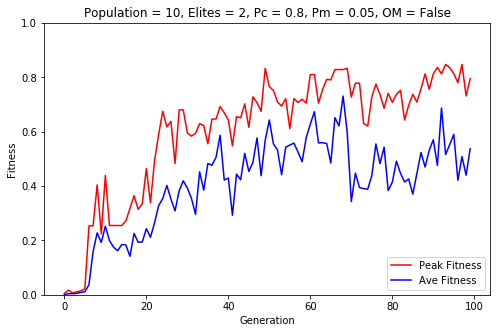

In [32]:
moveMotors(init_pos, motors)

nPop = 10
Pc = 0.8
Pm = 0.05
nElites = 2
nGen = 100
setMotorV(motors, speed = 2.0)

aveFit, peakFit, sampledN = gaScan(motors, nPopulation = nPop, Pc = Pc, Pm = Pm, nGenerations = nGen
                                   , nElite = nElites, OM = False, critVal = 0.90, seed = seed)



In [28]:
peakFit[-1]

0.9216405411914118

### OMEA - Oberver Mode Evolutionary Algorithm

In practice will have nPopulation = 10, but will track fitness during motor moves and replace individual/chromosome if "fitter" individual found on the way to destination.



In [33]:
moveMotors(init_pos, motors)

 
Total processing time 64 s
Total sampled individuals:  489


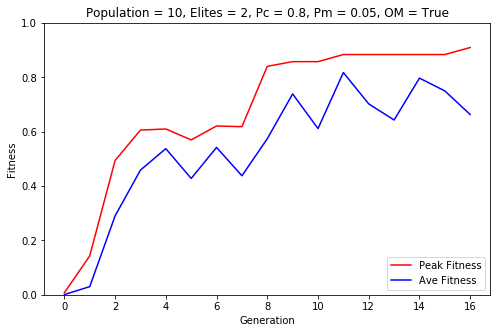

In [34]:
moveMotors(init_pos, motors)

nPop = 10
Pc = 0.8
Pm = 0.05
nElites = 2
nGen = 100
setMotorV(motors, speed = 0.2)

aveFit, peakFit, sampledN = gaScan(motors, nPopulation = nPop, Pc = Pc, Pm = Pm, nGenerations = nGen, 
                                   nElite = nElites, OM = True, critVal = 0.90, seed = seed)
print('Total sampled individuals: ',sampledN)

In [31]:
peakFit[-1]

0.9239475250726878

In [41]:
moveMotors(init_pos, motors)

 
Total processing time 73 s
Total sampled individuals:  425


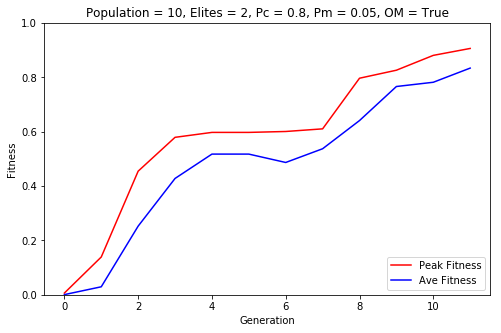

In [42]:
moveMotors(init_pos, motors)

nPop = 10
Pc = 0.8
Pm = 0.05
nElites = 2
nGen = 100
setMotorV(motors, speed = 0.5)

aveFit, peakFit, sampledN = gaScan(motors, nPopulation = nPop, Pc = Pc, Pm = Pm, nGenerations = nGen, 
                                   nElite = nElites, OM = True, critVal = 0.90, seed = seed)
print('Total sampled individuals: ',sampledN)

In [43]:
peakFit[-1]

0.9063769498779158

In [48]:
moveMotors(init_pos, motors)

 
Total processing time 678 s
Total sampled individuals:  2338


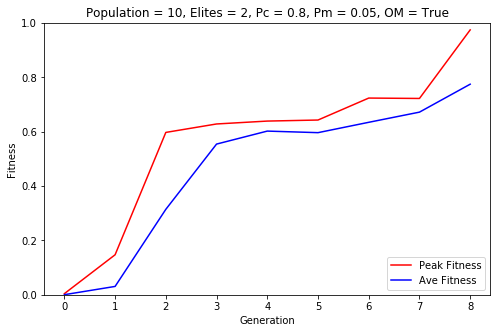

In [49]:
moveMotors(init_pos, motors)

nPop = 10
Pc = 0.8
Pm = 0.05
nElites = 2
nGen = 100
setMotorV(motors, speed = 0.1)

aveFit, peakFit, sampledN = gaScan(motors, nPopulation = nPop, Pc = Pc, Pm = Pm, nGenerations = nGen, 
                                   nElite = nElites, OM = True, critVal = 0.90, seed = seed)
print('Total sampled individuals: ',sampledN)

In [50]:
peakFit[-1]

0.9746274339850959